# INM702 Coursework Task 3 w/ Explainability - SHAP
### Aaron Mir (Student Number: 160001207)

To run Explainability code, run all cells in the initial section and then skip to the Explainability - SHAP section at the bottom of the notebook. 
    
        - load the model, optimiser and pretrained weights for each model then run SHAP deep explainer.


## Initial

In [4]:
import shap
import matplotlib.pyplot as plt
import numpy as np
import itertools
import time as t
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
from torch.autograd import Variable
import torchvision
from torchvision import transforms, datasets
import sklearn
from sklearn import metrics, preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, confusion_matrix

In [5]:
print(f"Python: {sys.version}")
print(f"Numpy Version: {np.__version__}")
print(f"PyTorch Version: {torch.__version__}")
print(f"Sklearn Version: {sklearn.__version__}")

Python: 3.8.7 (tags/v3.8.7:6503f05, Dec 21 2020, 17:59:51) [MSC v.1928 64 bit (AMD64)]
Numpy Version: 1.19.5
PyTorch Version: 1.7.1+cu110
Sklearn Version: 0.24.1


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
print(device)
print(torch.cuda.get_device_name(0))
print(torch.cuda.memory_allocated())
print(torch.cuda.memory_reserved())

cuda
GeForce RTX 3090
0
0


In [11]:
def MNIST_load(batch_size):
    trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, ), (0.5, ))]) # used to br 0.5
    train_set = datasets.MNIST(root='./dataTask3', train=True, download=True, transform=trans)
    test_set = datasets.MNIST(root='./dataTask3', train=False, download=True, transform=trans)
    train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False)
    return train_set, test_set, train_loader, test_loader

In [12]:
train_set, test_set, train_loader, test_loader = MNIST_load(128)

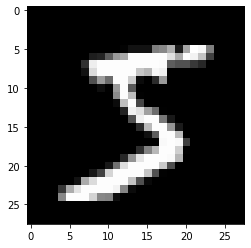

In [13]:
plt.imshow(train_set[0][0][0], cmap='gray');

In [14]:
print(len(train_loader))
print(len(test_loader))

469
79


In [15]:
for i, (images, labels) in enumerate(train_loader):           # checking to see if the data  is in the right format
    print(i, images.size(), len(labels))
    break

0 torch.Size([128, 1, 28, 28]) 128


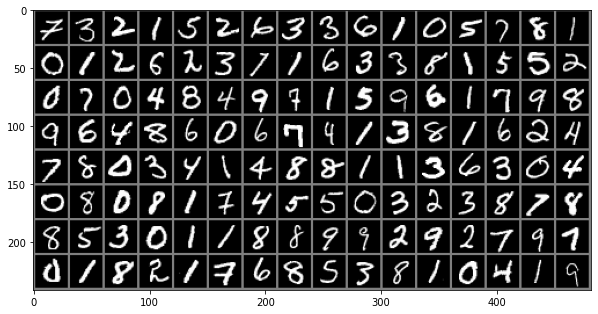

In [16]:
def imshow(img):
    img = img / 2 + 0.5     
    npimg = img.numpy()
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.show()

dataiter = iter(train_loader)                               # pulls one batch from the loader
images, labels = dataiter.next()                            # pulls out 64 images for one batch
imshow(torchvision.utils.make_grid(images, nrow=16))
images = images.to(device)
labels = labels.to(device)

In [17]:
def save_checkpoint(state, filename):
    print('=> Saving checkpoint')
    torch.save(state, filename)
    
def load_checkpoint(checkpoint, model, optimiser):
    print('=> Loading checkpoint')
    model.load_state_dict(checkpoint['state_dict'], strict=False)
    optimiser.load_state_dict(checkpoint['optimiser'])

## Training/Testing - Model 1

In [166]:
#------------------------------------------- Main Neural Network (Fully ReLU) --------------------------------#
class Neural_Network(nn.Module):
    def __init__(self):
        super(Neural_Network, self).__init__()
        self.fc1 = nn.Linear(784, 64)             # 784 inputs
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 10)              # 10 outputs - 0-9
    
    def forward(self, X):
        X = X.view(-1, 784)                       # flattens the tensor
        X = torch.relu(self.fc1(X))
        X = torch.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)
    
    def name(self):
        return "Neural_Network"

In [167]:
model = Neural_Network().to(device)
optimiser = optim.Adam(params=model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=0.0000001)
loss_fn = nn.CrossEntropyLoss()

In [168]:
epochs = 4
history_loss = []
start = t.time()
for epoch in range(epochs):
    train_loss = [] 
    model.train()
    for batch_idx, (X, y) in enumerate(train_loader):      # for each batch of images
        #------------Moving to device---------#
        X = X.to(device)  
        y = y.to(device)  
        #------------Forward Pass---------#
        optimiser.zero_grad()    
        y_pred = model(X) 
        loss = loss_fn(y_pred, y)
        #------------Backward Pass---------#
        loss.backward()
        optimiser.step()
        train_loss.append(loss.item())
    loss_now = np.mean(train_loss)
    history_loss.append(loss_now)
    print(f'epoch: {epoch}, train loss: {loss_now:.6f}')
end = t.time()
checkpoint = {
    "state_dict": model.state_dict(), 
    "optimiser": optimiser.state_dict(),}
save_checkpoint(checkpoint, filename='trainedReLU.pth.tar')
print('Training has taken ', end - start, 'seconds to complete')

epoch: 0, train loss: 0.360141
epoch: 1, train loss: 0.163079
epoch: 2, train loss: 0.117689
epoch: 3, train loss: 0.092424
=> Saving checkpoint
Training has taken  29.569433212280273 seconds to complete


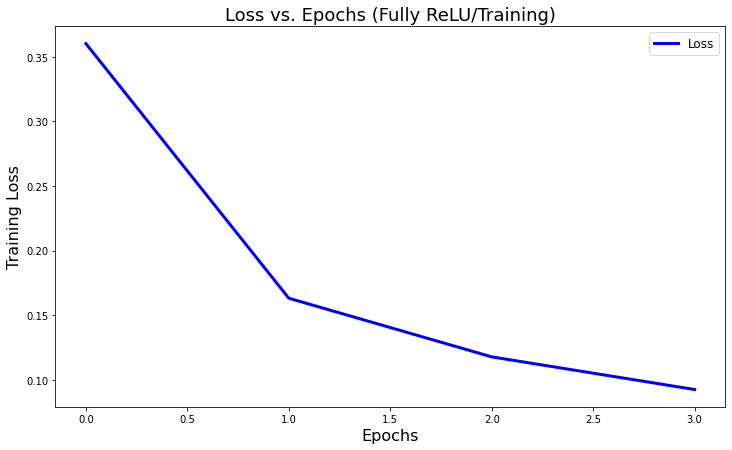

In [169]:
plt.figure(figsize=(12, 7))
plt.plot(history_loss, 'b', linewidth=3.0, label='Loss')
plt.title('Loss vs. Epochs (Fully ReLU/Training)', fontsize=18)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Training Loss', fontsize=16)
plt.legend(fontsize=12)
plt.show()

In [170]:
''' DEFINING CONFUSION MATRIX PLOT FUNCTION TAKEN FROM SKLEARN WEBSITE'''
def plot_confusion_matrix(cm, classes, 
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 968    0    1    1    0    2    2    1    2    3]
 [   0 1123    3    2    0    2    1    0    4    0]
 [   4    3  994    9    2    0    2    8   10    0]
 [   0    0    0  988    0   10    0    5    6    1]
 [   2    0    4    1  953    2    4    3    0   13]
 [   2    0    0    6    1  868    6    0    8    1]
 [   8    3    1    1    2    5  930    0    8    0]
 [   1    9    6    6    0    0    0  997    1    8]
 [   1    2    3    5    2    2    2    1  955    1]
 [   5    5    0    6   11    7    0    7    5  963]]
[98.7755102  98.94273128 96.31782946 97.82178218 97.04684318 97.30941704
 97.07724426 96.9844358  98.04928131 95.44103072]
              precision    recall  f1-score   support

           0      0.977     0.988     0.982       980
           1      0.981     0.989     0.985      1135
           2      0.982     0.963     0.973      1032
           3      0.964     0.978     0.971      1010
           4      0.981     0.970  

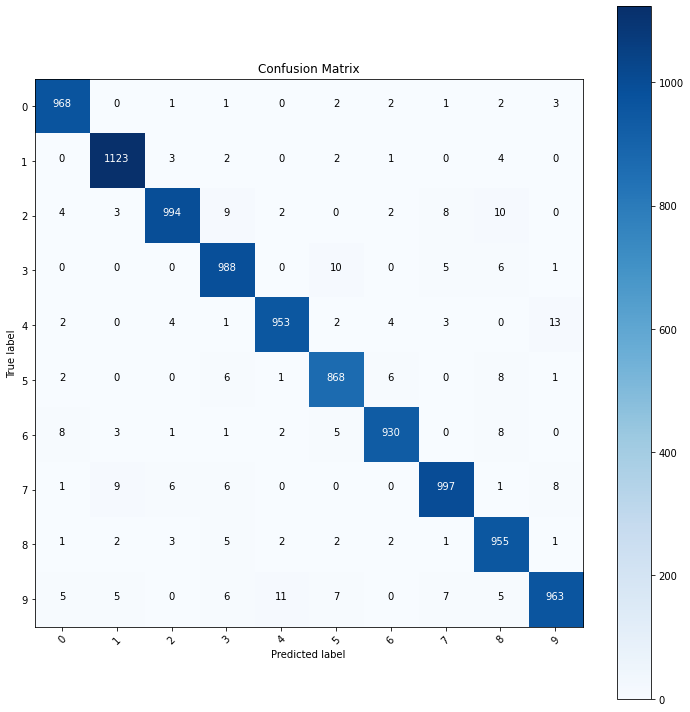

In [171]:
nb_classes = 9
# Initialize the prediction and label lists(tensors)
pred_list = torch.zeros(0,dtype=torch.long, device='cpu')
label_list = torch.zeros(0,dtype=torch.long, device='cpu')
with torch.no_grad():
    model.eval()
    for i, (X, y) in enumerate(test_loader):
        X = X.to(device)
        y = y.to(device)
        y_pred = model(X)
        _, preds = torch.max(y_pred, 1)
        # Append batch prediction results
        pred_list=torch.cat([pred_list,preds.view(-1).cpu()])
        label_list=torch.cat([label_list,y.view(-1).cpu()])
# Confusion matrix
cm=confusion_matrix(label_list.numpy(), pred_list.numpy())
cm_plot_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
plot_confusion_matrix(cm = cm, classes = cm_plot_labels, title = 'Confusion Matrix')
# Per-class accuracy
class_accuracy=100*cm.diagonal()/cm.sum(1)
print(class_accuracy)
print(classification_report(label_list.numpy(), pred_list.numpy(), digits=3))

## Training/Testing - Model 2

In [172]:
#------------------------------------------- Main Neural Network (Fully Sigmoid) --------------------------------#
class Neural_Network2(nn.Module):
    def __init__(self):
        super(Neural_Network2, self).__init__()
        self.fc1 = nn.Linear(784, 64)           # 784 inputs
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 10)            # 10 outputs - 0-9
    
    def forward(self, X):
        X = X.view(-1, 784)                     # flattens the tensor
        X = torch.sigmoid(self.fc1(X))
        X = torch.sigmoid(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)
    
    def name(self):
        return "Neural_Network2"

In [173]:
model2 = Neural_Network2().to(device)
optimiser = optim.Adam(model2.parameters(), lr=0.001, betas=(0.9, 0.999), eps=0.0000001)
loss_fn = nn.CrossEntropyLoss()

In [174]:
epochs = 4
history_loss = []
start = t.time()
for epoch in range(epochs):
    train_loss = [] 
    model2.train()
    for batch_idx, (X, y) in enumerate(train_loader):      #for each batch of images
        #------------Moving to device---------#
        X = X.to(device)  
        y = y.to(device)  
        #------------Forward Pass---------#
        optimiser.zero_grad()    
        y_pred = model2(X) # X.view(-1, 784)
        loss = loss_fn(y_pred, y)
        #------------Backward Pass---------#
        loss.backward()
        optimiser.step()
        train_loss.append(loss.item())
    loss_now = np.mean(train_loss)
    history_loss.append(loss_now)
    print(f'epoch: {epoch}, train loss: {loss_now:.6f}')
end = t.time()
print('Training has taken ', end - start, 'seconds to complete')
checkpoint = {
    "state_dict": model2.state_dict(), 
    "optimiser": optimiser.state_dict(),}
save_checkpoint(checkpoint, filename='trainedSigmoid.pth.tar')
print('Training has taken ', end - start, 'seconds to complete')

epoch: 0, train loss: 0.936956
epoch: 1, train loss: 0.279021
epoch: 2, train loss: 0.192690
epoch: 3, train loss: 0.151176
Training has taken  29.70328116416931 seconds to complete
=> Saving checkpoint
Training has taken  29.70328116416931 seconds to complete


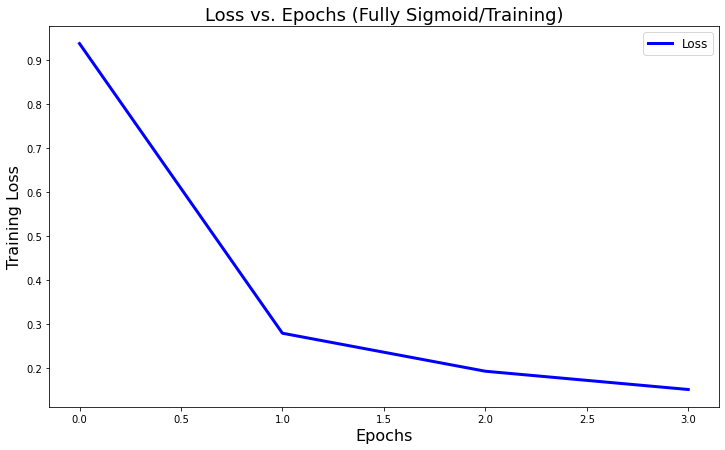

In [175]:
plt.figure(figsize=(12, 7))
plt.plot(history_loss, 'b', linewidth=3.0, label='Loss')
plt.title('Loss vs. Epochs (Fully Sigmoid/Training)', fontsize=18)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Training Loss', fontsize=16)
plt.legend(fontsize=12)
plt.show()

Confusion matrix, without normalization
[[ 971    0    1    1    0    3    2    1    1    0]
 [   0 1116    2    3    0    0    3    2    9    0]
 [  12    2  980    5    5    1    5    9   12    1]
 [   2    0   11  958    1   13    0   12   11    2]
 [   1    0    4    0  935    0    7    1    5   29]
 [   7    1    3   21    2  827    8    3   15    5]
 [  12    2    3    0    6    8  922    1    4    0]
 [   1    6   18    3    2    1    0  983    0   14]
 [   5    1    6   14    3    4    6    5  928    2]
 [   7    2    1    7   13    6    0   11   13  949]]
[99.08163265 98.32599119 94.96124031 94.85148515 95.21384929 92.71300448
 96.24217119 95.62256809 95.27720739 94.05351833]
              precision    recall  f1-score   support

           0      0.954     0.991     0.972       980
           1      0.988     0.983     0.985      1135
           2      0.952     0.950     0.951      1032
           3      0.947     0.949     0.948      1010
           4      0.967     0.952  

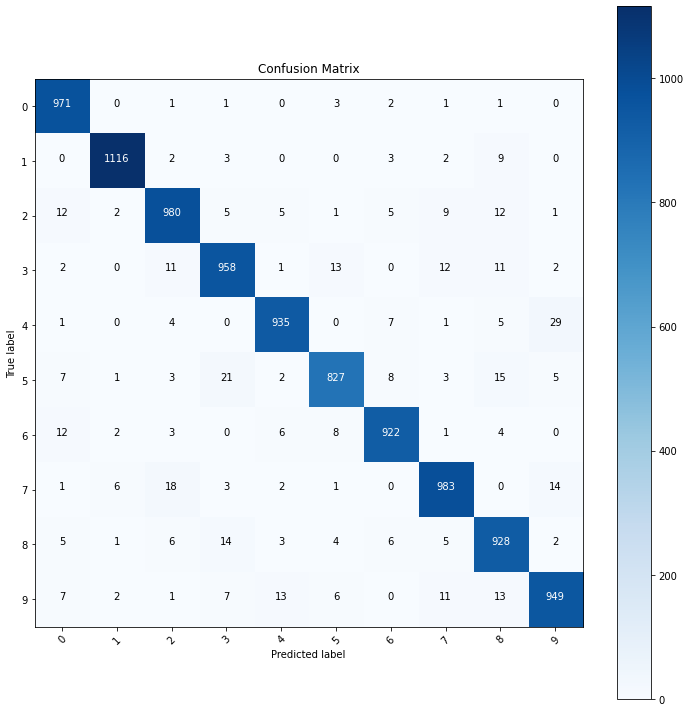

In [176]:
nb_classes = 9
# initialise the prediction and label lists(tensors)
pred_list = torch.zeros(0,dtype=torch.long, device='cpu')
label_list = torch.zeros(0,dtype=torch.long, device='cpu')
with torch.no_grad():
    model2.eval()
    for i, (X, y) in enumerate(test_loader):
        X = X.to(device)
        y = y.to(device)
        y_pred = model2(X)
        _, preds = torch.max(y_pred, 1)
        # append batch prediction results
        pred_list = torch.cat([pred_list,preds.view(-1).cpu()])
        label_list = torch.cat([label_list,y.view(-1).cpu()])
# confusion matrix
cm=confusion_matrix(label_list.numpy(), pred_list.numpy())
cm_plot_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
plot_confusion_matrix(cm = cm, classes = cm_plot_labels, title = 'Confusion Matrix')
# per-class accuracy
class_accuracy = 100 * cm.diagonal()/cm.sum(1)
print(class_accuracy)
print(classification_report(label_list.numpy(), pred_list.numpy(), digits=3))

## Training/Testing - Model 3

In [38]:
#------------------------------------------- Main Neural Network (CNN) --------------------------------#
class Neural_Network3(nn.Module):
    def __init__(self):
        super(Neural_Network3, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, 3) 
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2)

        self.fc1 = nn.Linear(64*6*6,600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(600, 120)
        self.fc3 = nn.Linear(120, 10)
        
    def forward(self, X):
        X = self.pool1(F.relu(self.bn1(self.conv1(X))))
        X = self.pool2(F.relu(self.bn2(self.conv2(X))))
        X = X.view(-1, 64*6*6)
        X = self.fc1(X)
        X = self.drop(X)
        X = self.fc2(X)
        X = self.fc3(X)   
        return F.log_softmax(X, dim=1)
    
    def name(self):
        return "Neural_Network3"

In [39]:
model3 = Neural_Network3().to(device)
optimiser = optim.Adam(model3.parameters(), lr=0.001, betas=(0.9, 0.999), eps=0.0000001)
loss_fn = nn.CrossEntropyLoss()

In [40]:
epochs = 4
history_loss = []
start = t.time()
for epoch in range(epochs):
    train_loss = [] 
    model3.train()
    for batch_idx, (X, y) in enumerate(train_loader):      # for each batch of images
        #------------Moving to device---------#
        X = X.to(device)  
        y = y.to(device)  
        #------------Forward Pass---------#
        optimiser.zero_grad()    
        y_pred = model3(X) 
        loss = loss_fn(y_pred, y)
        #------------Backward Pass---------#
        loss.backward()
        optimiser.step()
        train_loss.append(loss.item())
    loss_now = np.mean(train_loss)
    history_loss.append(loss_now)
    print(f'epoch: {epoch}, train loss: {loss_now:.6f}')
end = t.time()
checkpoint = {
    "state_dict": model3.state_dict(), 
    "optimiser": optimiser.state_dict(),}
save_checkpoint(checkpoint, filename='trainedCNN.pth.tar')
print('Training has taken ', end - start, 'seconds to complete')

epoch: 0, train loss: 0.159977
epoch: 1, train loss: 0.073445
epoch: 2, train loss: 0.056221
epoch: 3, train loss: 0.044195
=> Saving checkpoint
Training has taken  37.57730555534363 seconds to complete


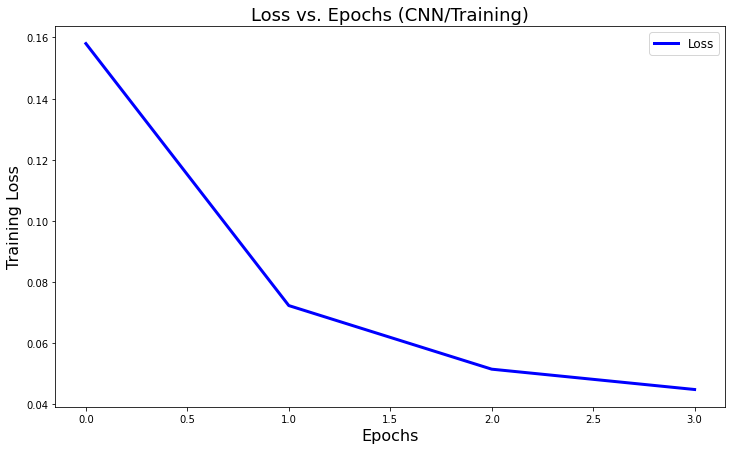

In [181]:
plt.figure(figsize=(12, 7))
plt.plot(history_loss, 'b', linewidth=3.0, label='Loss')
plt.title('Loss vs. Epochs (CNN/Training)', fontsize=18)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Training Loss', fontsize=16)
plt.legend(fontsize=12)
plt.show()

Confusion matrix, without normalization
[[ 976    1    0    0    0    0    0    1    1    1]
 [   0 1130    2    0    0    0    0    2    1    0]
 [   1    0 1023    0    0    0    0    6    2    0]
 [   1    0    2  996    0    6    0    3    2    0]
 [   1    0    0    0  957    0    0    5    2   17]
 [   2    1    1    3    0  880    1    1    1    2]
 [  10    5    0    0    1    2  937    0    3    0]
 [   0    1    4    0    0    0    0 1022    1    0]
 [   3    0    2    1    1    1    0    1  962    3]
 [   1    3    0    0    4    1    0    5    3  992]]
[99.59183673 99.55947137 99.12790698 98.61386139 97.45417515 98.65470852
 97.80793319 99.41634241 98.76796715 98.31516353]
              precision    recall  f1-score   support

           0      0.981     0.996     0.988       980
           1      0.990     0.996     0.993      1135
           2      0.989     0.991     0.990      1032
           3      0.996     0.986     0.991      1010
           4      0.994     0.975  

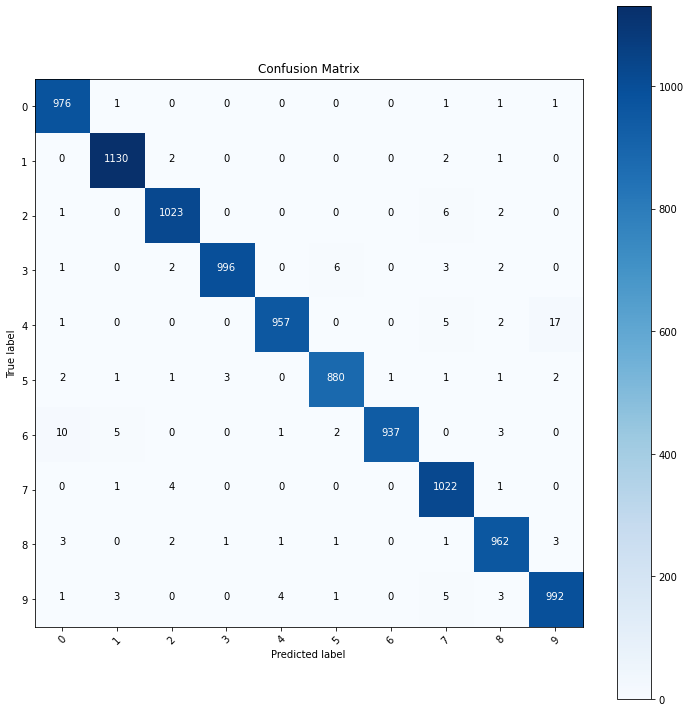

In [182]:
nb_classes = 9
# initialise the prediction and label lists(tensors)
pred_list = torch.zeros(0,dtype=torch.long, device='cpu')
label_list = torch.zeros(0,dtype=torch.long, device='cpu')
with torch.no_grad():
    model3.eval()
    for i, (X, y) in enumerate(test_loader):
        X = X.to(device)
        y = y.to(device)
        y_pred = model3(X)
        _, preds = torch.max(y_pred, 1)
        # append batch prediction results
        pred_list = torch.cat([pred_list,preds.view(-1).cpu()])
        label_list = torch.cat([label_list,y.view(-1).cpu()])
# confusion matrix
cm=confusion_matrix(label_list.numpy(), pred_list.numpy())
cm_plot_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
plot_confusion_matrix(cm = cm, classes = cm_plot_labels, title = 'Confusion Matrix')
# per-class accuracy
class_accuracy = 100*cm.diagonal()/cm.sum(1)
print(class_accuracy)
print(classification_report(label_list.numpy(), pred_list.numpy(), digits=3))

## Explainability for each model - SHAP

In [46]:
##--------------------Coding References---------------------##
# Hiros (2019) Explain Image Classification by SHAP Deep Explainer, Available at: https://h1ros.github.io/posts/explain-image-classification-by-shap-deep-explainer/ (Accessed: 29th April 2021).

In [47]:
#------------------------------------------- Main Neural Network (Fully ReLU) --------------------------------#
class Neural_Network(nn.Module):
    def __init__(self):
        super(Neural_Network, self).__init__()
        self.fc1 = nn.Linear(784, 64)             # 784 inputs
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 10)              # 10 outputs - 0-9
    
    def forward(self, X):
        X = X.view(-1, 784)                       # flattens the tensor
        X = torch.relu(self.fc1(X))
        X = torch.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)
    
    def name(self):
        return "Neural_Network"

In [48]:
model = Neural_Network().to(device)
optimiser = optim.Adam(params=model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=0.0000001)
loss_fn = nn.CrossEntropyLoss()

In [49]:
load_checkpoint(torch.load('trainedReLU.pth.tar'), model, optimiser)  # loading pretrained model weights

=> Loading checkpoint


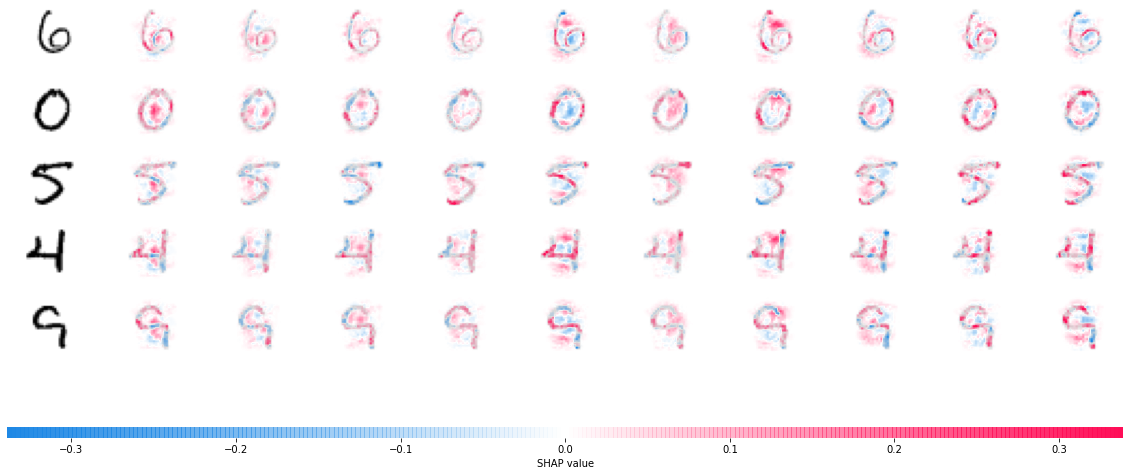

In [50]:
batch = next(iter(test_loader))
images, _ = batch

background = images[:100].to(device)
test_images = images[100:105].to(device)

explainer = shap.DeepExplainer(model, background)
shap_values = explainer.shap_values(test_images)

shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.cpu().numpy(), 1, -1), 1, 2)
shap.image_plot(shap_numpy, -test_numpy)

In [51]:
#------------------------------------------- Main Neural Network (Fully Sigmoid) --------------------------------#
class Neural_Network2(nn.Module):
    def __init__(self):
        super(Neural_Network2, self).__init__()
        self.fc1 = nn.Linear(784, 64)           # 784 inputs
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 10)            # 10 outputs - 0-9
    
    def forward(self, X):
        X = X.view(-1, 784)                     # flattens the tensor
        X = torch.sigmoid(self.fc1(X))
        X = torch.sigmoid(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)
    
    def name(self):
        return "Neural_Network2"

In [52]:
model2 = Neural_Network2().to(device)
optimiser = optim.Adam(model2.parameters(), lr=0.001, betas=(0.9, 0.999), eps=0.0000001)
loss_fn = nn.CrossEntropyLoss()

In [53]:
load_checkpoint(torch.load('trainedSigmoid.pth.tar'), model2, optimiser) # loading pretrained model weights

=> Loading checkpoint


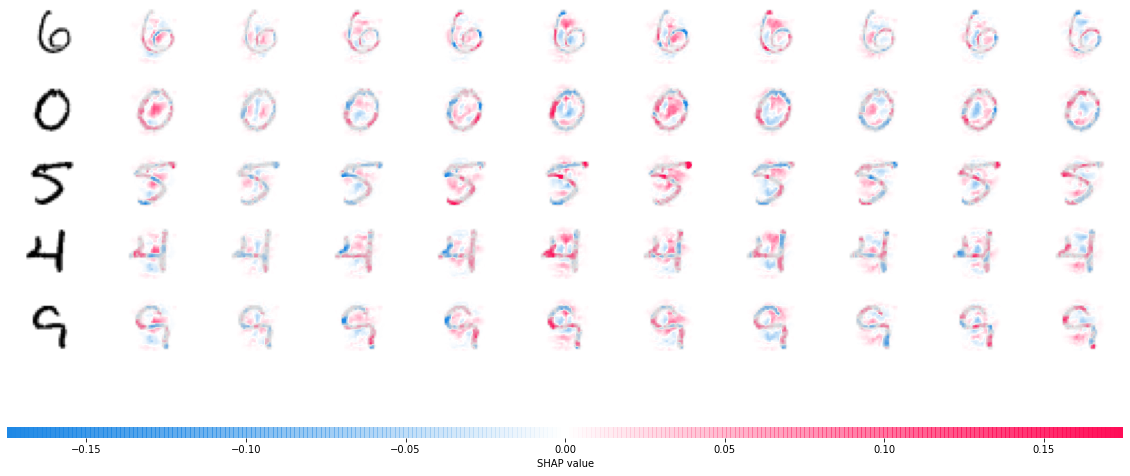

In [54]:
batch = next(iter(test_loader))
images, _ = batch

background = images[:100].to(device)
test_images = images[100:105].to(device)

explainer = shap.DeepExplainer(model2, background)
shap_values = explainer.shap_values(test_images)

shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.cpu().numpy(), 1, -1), 1, 2)
shap.image_plot(shap_numpy, -test_numpy)

In [55]:
#------------------------------------------- Main Neural Network (CNN) --------------------------------#
class Neural_Network3(nn.Module):
    def __init__(self):
        super(Neural_Network3, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, 3) 
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2)

        self.fc1 = nn.Linear(64*6*6,600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(600, 120)
        self.fc3 = nn.Linear(120, 10)
        
    def forward(self, X):
        X = self.pool1(F.relu(self.bn1(self.conv1(X))))
        X = self.pool2(F.relu(self.bn2(self.conv2(X))))
        X = X.view(-1, 64*6*6)
        X = self.fc1(X)
        X = self.drop(X)
        X = self.fc2(X)
        X = self.fc3(X)   
        return F.log_softmax(X, dim=1)
    
    def name(self):
        return "Neural_Network3"

In [56]:
model3 = Neural_Network3().to(device)
optimiser = optim.Adam(model3.parameters(), lr=0.001, betas=(0.9, 0.999), eps=0.0000001)
loss_fn = nn.CrossEntropyLoss()

In [57]:
load_checkpoint(torch.load('trainedCNN.pth.tar'), model3, optimiser) 

=> Loading checkpoint


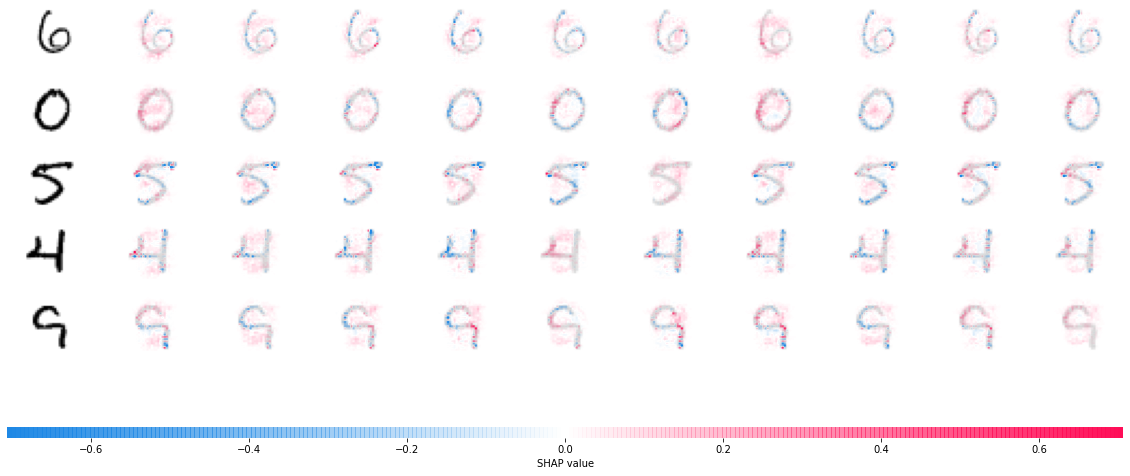

In [58]:
batch = next(iter(test_loader))
images, _ = batch

background = images[:100].to(device)
test_images = images[100:105].to(device)

explainer = shap.DeepExplainer(model3, background)
shap_values = explainer.shap_values(test_images)

shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.cpu().numpy(), 1, -1), 1, 2)
shap.image_plot(shap_numpy, -test_numpy)